In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results_v1/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. Trying to reduce it: v1. 255 Normalization. Weighted for Precision.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

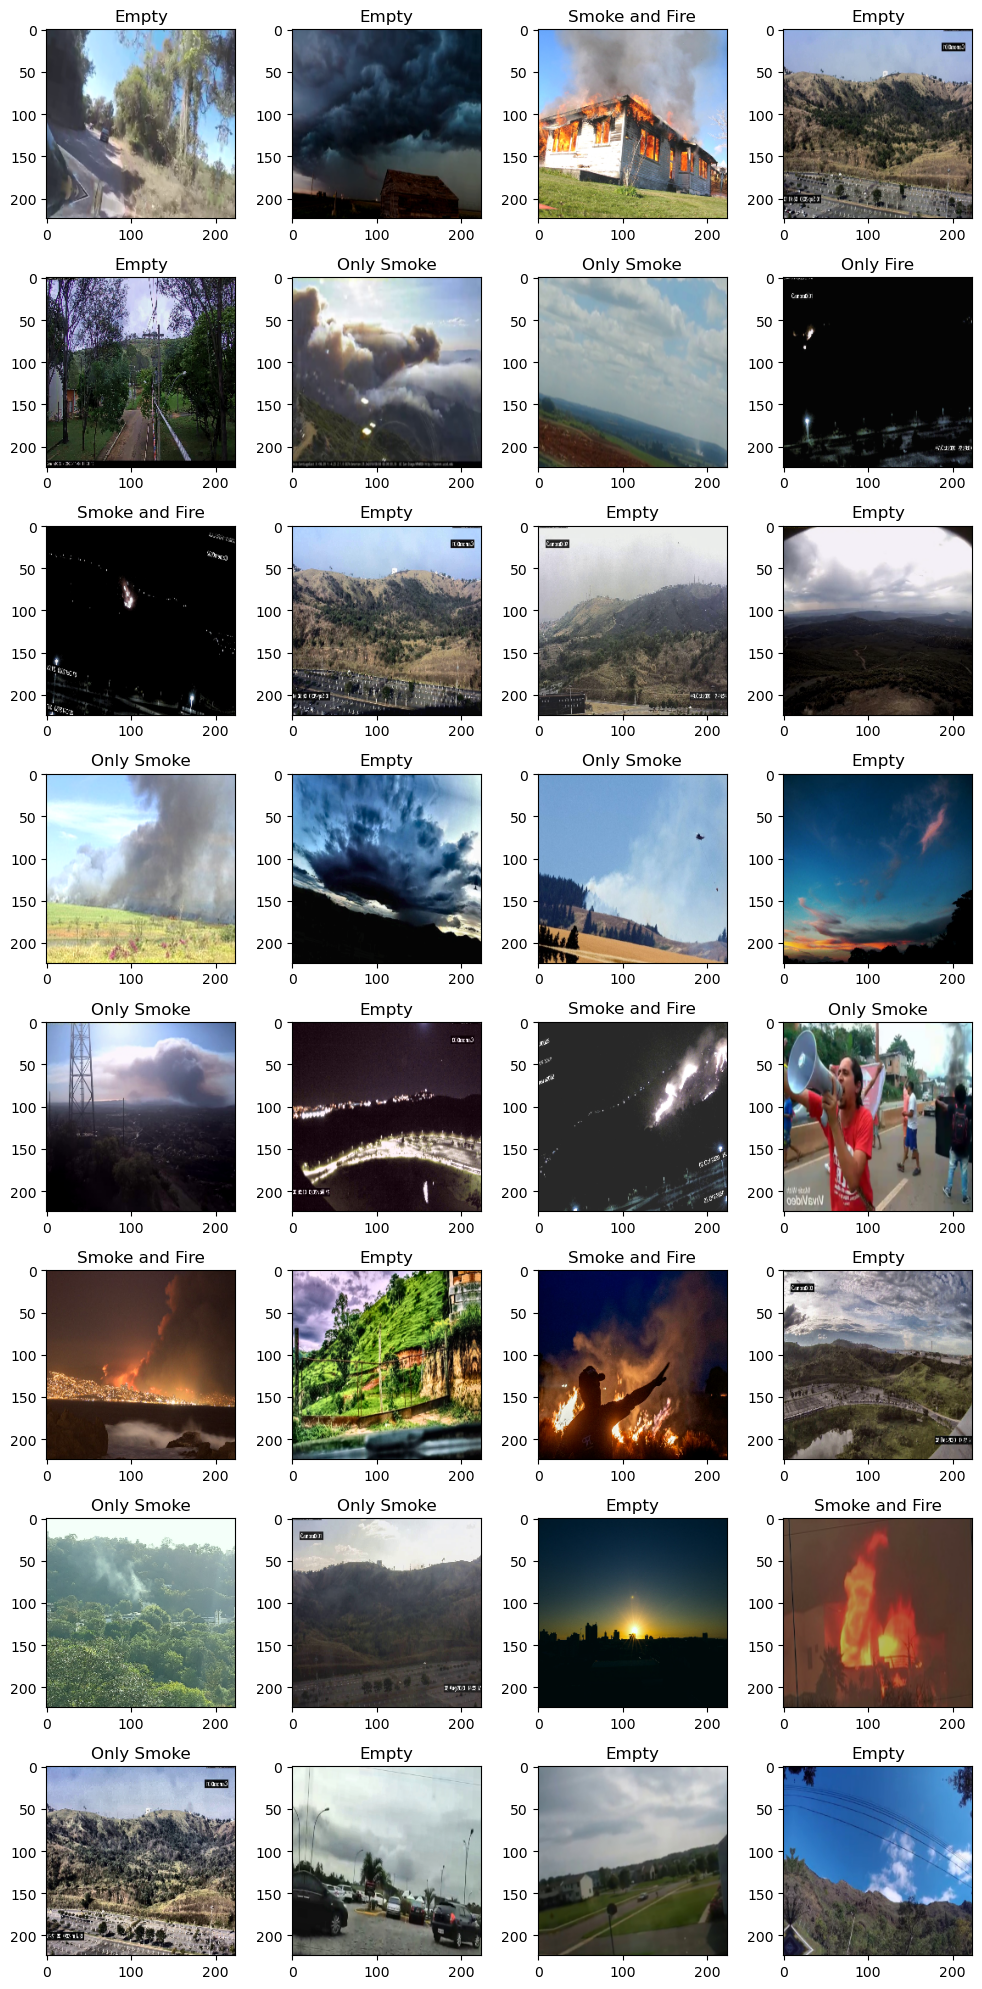

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(32, 8, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(8, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
EPOCHS = 125 #100
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[0.0586, 0.2620],
        [0.0111, 0.0505],
        [0.1665, 0.1466],
        [0.1597, 0.2772]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, 

# Main Function

In [18]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])
    smoke_f1_min_save = torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < v_pre[0].detach().to('cpu') ) and ( v_f1[0].detach().to('cpu') > smoke_f1_min_save ) :
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 21:49:35

Initializing Weights

=== EPOCH 0/124 ===
Learning Rate = 0.001



Training:   0%|                                         | 0/269 [00:00<?, ?it/s]/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.353      |36.592      |32.760      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.297      |35.951      |25.346      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.741 - F1: 0.000

Saving model with new best validation loss: 61.297

=== EPOCH 1/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.591      |35.935      |26.655      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.515      |35.686      |22.830      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.752 - Recall: 0.606 - Accuracy: 0.846 - F1: 0.671

Saving model with new best validation loss: 58.515

=== EPOCH 2/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.219      |35.341      |24.878      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.181      |34.416      |21.764      

SMOKE -> Precision: 0.643 - Recall: 0.309 - Accuracy: 0.585 - F1: 0.418
FIRE -> Precision: 0.784 - Recall: 0.605 - Accuracy: 0.855 - F1: 0.683

Saving model with new best validation loss: 56.181

=== EPOCH 3/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.531      |34.732      |23.798      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.839      |34.531      |21.308      

SMOKE -> Precision: 0.813 - Recall: 0.162 - Accuracy: 0.579 - F1: 0.271
FIRE -> Precision: 0.785 - Recall: 0.612 - Accuracy: 0.856 - F1: 0.688

Saving model with new best validation loss: 55.839

=== EPOCH 4/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.835      |34.012      |22.824      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.176      |32.400      |19.775      

SMOKE -> Precision: 0.770 - Recall: 0.346 - Accuracy: 0.636 - F1: 0.478
FIRE -> Precision: 0.797 - Recall: 0.698 - Accuracy: 0.876 - F1: 0.744

Saving model with new best validation loss: 52.176

=== EPOCH 5/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.329      |33.367      |21.962      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.818      |31.703      |19.116      

SMOKE -> Precision: 0.817 - Recall: 0.319 - Accuracy: 0.638 - F1: 0.459
FIRE -> Precision: 0.797 - Recall: 0.677 - Accuracy: 0.872 - F1: 0.732

Saving model with new best validation loss: 50.818

=== EPOCH 6/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.213      |32.864      |21.349      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.711      |30.999      |18.712      

SMOKE -> Precision: 0.764 - Recall: 0.527 - Accuracy: 0.694 - F1: 0.624
FIRE -> Precision: 0.786 - Recall: 0.732 - Accuracy: 0.879 - F1: 0.758

Saving model with new best validation loss: 49.711

=== EPOCH 7/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.636      |32.197      |20.439      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.265      |30.769      |18.496      

SMOKE -> Precision: 0.724 - Recall: 0.527 - Accuracy: 0.676 - F1: 0.610
FIRE -> Precision: 0.777 - Recall: 0.749 - Accuracy: 0.879 - F1: 0.763

Saving model with new best validation loss: 49.265

=== EPOCH 8/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.653      |31.645      |20.008      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.398      |29.165      |17.233      

SMOKE -> Precision: 0.806 - Recall: 0.501 - Accuracy: 0.702 - F1: 0.618
FIRE -> Precision: 0.832 - Recall: 0.728 - Accuracy: 0.892 - F1: 0.777

Saving model with new best validation loss: 46.398

=== EPOCH 9/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.178      |31.020      |19.159      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.575      |29.006      |16.570      

SMOKE -> Precision: 0.758 - Recall: 0.719 - Accuracy: 0.754 - F1: 0.738
FIRE -> Precision: 0.831 - Recall: 0.769 - Accuracy: 0.900 - F1: 0.799

Saving model with new best validation loss: 45.575

=== EPOCH 10/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.226      |30.550      |18.676      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.012      |27.966      |16.045      

SMOKE -> Precision: 0.813 - Recall: 0.544 - Accuracy: 0.720 - F1: 0.652
FIRE -> Precision: 0.867 - Recall: 0.764 - Accuracy: 0.909 - F1: 0.812

Saving model with new best validation loss: 44.012

=== EPOCH 11/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.501      |30.142      |18.359      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.041      |28.408      |15.633      

SMOKE -> Precision: 0.842 - Recall: 0.462 - Accuracy: 0.700 - F1: 0.597
FIRE -> Precision: 0.854 - Recall: 0.767 - Accuracy: 0.906 - F1: 0.808

=== EPOCH 12/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.343      |29.436      |17.907      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.943      |26.615      |15.328      

SMOKE -> Precision: 0.849 - Recall: 0.549 - Accuracy: 0.736 - F1: 0.667
FIRE -> Precision: 0.865 - Recall: 0.765 - Accuracy: 0.908 - F1: 0.812

Saving model with new best validation loss: 41.943

=== EPOCH 13/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.749      |29.055      |17.694      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.840      |25.890      |14.949      

SMOKE -> Precision: 0.828 - Recall: 0.630 - Accuracy: 0.759 - F1: 0.716
FIRE -> Precision: 0.841 - Recall: 0.798 - Accuracy: 0.909 - F1: 0.819

Saving model with new best validation loss: 40.840

=== EPOCH 14/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.794      |28.664      |17.131      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.017      |25.650      |15.367      

SMOKE -> Precision: 0.786 - Recall: 0.778 - Accuracy: 0.792 - F1: 0.782
FIRE -> Precision: 0.902 - Recall: 0.723 - Accuracy: 0.908 - F1: 0.802

=== EPOCH 15/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.039      |28.177      |16.862      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.172      |25.844      |14.328      

SMOKE -> Precision: 0.758 - Recall: 0.815 - Accuracy: 0.786 - F1: 0.785
FIRE -> Precision: 0.849 - Recall: 0.813 - Accuracy: 0.914 - F1: 0.830

Saving model with new best validation loss: 40.172

=== EPOCH 16/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.673      |28.072      |16.602      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.021      |26.265      |14.756      

SMOKE -> Precision: 0.731 - Recall: 0.870 - Accuracy: 0.783 - F1: 0.794
FIRE -> Precision: 0.785 - Recall: 0.877 - Accuracy: 0.906 - F1: 0.828

=== EPOCH 17/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.799      |27.648      |16.151      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.138      |24.090      |14.048      

SMOKE -> Precision: 0.820 - Recall: 0.707 - Accuracy: 0.785 - F1: 0.759
FIRE -> Precision: 0.881 - Recall: 0.767 - Accuracy: 0.913 - F1: 0.820

Saving model with new best validation loss: 38.138

=== EPOCH 18/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.277      |27.311      |15.966      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.391      |23.976      |13.416      

SMOKE -> Precision: 0.814 - Recall: 0.730 - Accuracy: 0.790 - F1: 0.770
FIRE -> Precision: 0.888 - Recall: 0.793 - Accuracy: 0.920 - F1: 0.838

Saving model with new best validation loss: 37.391

=== EPOCH 19/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.862      |27.190      |15.672      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.025      |24.427      |13.598      

SMOKE -> Precision: 0.880 - Recall: 0.571 - Accuracy: 0.756 - F1: 0.693
FIRE -> Precision: 0.878 - Recall: 0.785 - Accuracy: 0.916 - F1: 0.829

=== EPOCH 20/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.247      |26.685      |15.562      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.989      |23.108      |12.881      

SMOKE -> Precision: 0.849 - Recall: 0.661 - Accuracy: 0.780 - F1: 0.743
FIRE -> Precision: 0.879 - Recall: 0.818 - Accuracy: 0.924 - F1: 0.847

Saving model with new best validation loss: 35.989

=== EPOCH 21/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.849      |26.547      |15.303      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.895      |23.229      |12.667      

SMOKE -> Precision: 0.830 - Recall: 0.707 - Accuracy: 0.789 - F1: 0.763
FIRE -> Precision: 0.863 - Recall: 0.851 - Accuracy: 0.927 - F1: 0.857

Saving model with new best validation loss: 35.895

=== EPOCH 22/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.178      |26.141      |15.037      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.978      |22.598      |12.380      

SMOKE -> Precision: 0.821 - Recall: 0.777 - Accuracy: 0.811 - F1: 0.799
FIRE -> Precision: 0.896 - Recall: 0.819 - Accuracy: 0.928 - F1: 0.856

Saving model with new best validation loss: 34.978

=== EPOCH 23/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.807      |26.084      |14.722      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.563      |22.671      |11.891      

SMOKE -> Precision: 0.787 - Recall: 0.857 - Accuracy: 0.820 - F1: 0.821
FIRE -> Precision: 0.882 - Recall: 0.841 - Accuracy: 0.930 - F1: 0.861

Saving model with new best validation loss: 34.563

=== EPOCH 24/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.051      |25.671      |14.381      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.047      |21.854      |12.194      

SMOKE -> Precision: 0.870 - Recall: 0.655 - Accuracy: 0.787 - F1: 0.747
FIRE -> Precision: 0.912 - Recall: 0.807 - Accuracy: 0.930 - F1: 0.857

Saving model with new best validation loss: 34.047

=== EPOCH 25/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.837      |25.317      |14.519      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.287      |22.528      |11.760      

SMOKE -> Precision: 0.856 - Recall: 0.658 - Accuracy: 0.782 - F1: 0.744
FIRE -> Precision: 0.911 - Recall: 0.819 - Accuracy: 0.932 - F1: 0.862

=== EPOCH 26/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.631      |25.341      |14.290      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.483      |20.858      |11.625      

SMOKE -> Precision: 0.861 - Recall: 0.736 - Accuracy: 0.816 - F1: 0.794
FIRE -> Precision: 0.884 - Recall: 0.853 - Accuracy: 0.933 - F1: 0.868

Saving model with new best validation loss: 32.483

=== EPOCH 27/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.925      |24.840      |14.085      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.917      |20.812      |11.105      

SMOKE -> Precision: 0.847 - Recall: 0.778 - Accuracy: 0.825 - F1: 0.811
FIRE -> Precision: 0.896 - Recall: 0.843 - Accuracy: 0.934 - F1: 0.869

Saving model with new best validation loss: 31.917

=== EPOCH 28/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.707      |24.729      |13.978      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.964      |20.828      |11.136      

SMOKE -> Precision: 0.862 - Recall: 0.720 - Accuracy: 0.810 - F1: 0.784
FIRE -> Precision: 0.911 - Recall: 0.844 - Accuracy: 0.938 - F1: 0.877

=== EPOCH 29/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.689      |24.953      |13.736      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.296      |21.100      |11.196      

SMOKE -> Precision: 0.883 - Recall: 0.679 - Accuracy: 0.802 - F1: 0.767
FIRE -> Precision: 0.893 - Recall: 0.862 - Accuracy: 0.938 - F1: 0.877

=== EPOCH 30/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.256      |24.730      |13.527      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.065      |22.186      |10.879      

SMOKE -> Precision: 0.788 - Recall: 0.874 - Accuracy: 0.826 - F1: 0.829
FIRE -> Precision: 0.902 - Recall: 0.859 - Accuracy: 0.939 - F1: 0.880

=== EPOCH 31/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.824      |24.489      |13.335      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.714      |20.342      |10.372      

SMOKE -> Precision: 0.836 - Recall: 0.798 - Accuracy: 0.827 - F1: 0.816
FIRE -> Precision: 0.875 - Recall: 0.892 - Accuracy: 0.939 - F1: 0.884

Saving model with new best validation loss: 30.714

=== EPOCH 32/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.708      |24.203      |13.505      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.882      |21.595      |10.287      

SMOKE -> Precision: 0.887 - Recall: 0.660 - Accuracy: 0.796 - F1: 0.757
FIRE -> Precision: 0.889 - Recall: 0.869 - Accuracy: 0.938 - F1: 0.879

=== EPOCH 33/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.700      |23.909      |12.791      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.370      |20.108      |10.261      

SMOKE -> Precision: 0.857 - Recall: 0.759 - Accuracy: 0.823 - F1: 0.805
FIRE -> Precision: 0.883 - Recall: 0.886 - Accuracy: 0.940 - F1: 0.885

Saving model with new best validation loss: 30.370

=== EPOCH 34/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.205      |24.113      |13.092      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.233      |21.118      |12.116      

SMOKE -> Precision: 0.896 - Recall: 0.677 - Accuracy: 0.807 - F1: 0.771
FIRE -> Precision: 0.948 - Recall: 0.758 - Accuracy: 0.927 - F1: 0.842

=== EPOCH 35/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.632      |23.790      |12.842      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.927      |18.948      |9.979       

SMOKE -> Precision: 0.874 - Recall: 0.803 - Accuracy: 0.849 - F1: 0.837
FIRE -> Precision: 0.891 - Recall: 0.895 - Accuracy: 0.944 - F1: 0.893

Saving model with new best validation loss: 28.927

=== EPOCH 36/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.322      |23.439      |12.883      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.348      |19.724      |10.623      

SMOKE -> Precision: 0.876 - Recall: 0.757 - Accuracy: 0.831 - F1: 0.812
FIRE -> Precision: 0.855 - Recall: 0.917 - Accuracy: 0.938 - F1: 0.885

=== EPOCH 37/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.138      |23.575      |12.563      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.175      |18.589      |9.586       

SMOKE -> Precision: 0.861 - Recall: 0.840 - Accuracy: 0.858 - F1: 0.850
FIRE -> Precision: 0.892 - Recall: 0.899 - Accuracy: 0.946 - F1: 0.895

Saving model with new best validation loss: 28.175

=== EPOCH 38/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.729      |23.202      |12.527      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.972      |19.277      |9.695       

SMOKE -> Precision: 0.887 - Recall: 0.742 - Accuracy: 0.830 - F1: 0.808
FIRE -> Precision: 0.881 - Recall: 0.919 - Accuracy: 0.947 - F1: 0.899

=== EPOCH 39/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.859      |23.320      |12.539      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.122      |19.194      |9.928       

SMOKE -> Precision: 0.872 - Recall: 0.790 - Accuracy: 0.843 - F1: 0.829
FIRE -> Precision: 0.927 - Recall: 0.841 - Accuracy: 0.942 - F1: 0.882

=== EPOCH 40/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.691      |23.195      |12.496      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.163      |18.102      |9.061       

SMOKE -> Precision: 0.864 - Recall: 0.852 - Accuracy: 0.864 - F1: 0.858
FIRE -> Precision: 0.916 - Recall: 0.869 - Accuracy: 0.946 - F1: 0.892

Saving model with new best validation loss: 27.163

=== EPOCH 41/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.904      |23.385      |12.519      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.684      |19.267      |9.417       

SMOKE -> Precision: 0.817 - Recall: 0.878 - Accuracy: 0.847 - F1: 0.847
FIRE -> Precision: 0.886 - Recall: 0.915 - Accuracy: 0.948 - F1: 0.900

=== EPOCH 42/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.998      |22.998      |12.000      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.975      |18.487      |9.488       

SMOKE -> Precision: 0.872 - Recall: 0.799 - Accuracy: 0.847 - F1: 0.834
FIRE -> Precision: 0.886 - Recall: 0.897 - Accuracy: 0.944 - F1: 0.892

=== EPOCH 43/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.966      |22.679      |12.287      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.886      |19.381      |9.505       

SMOKE -> Precision: 0.902 - Recall: 0.713 - Accuracy: 0.824 - F1: 0.796
FIRE -> Precision: 0.916 - Recall: 0.884 - Accuracy: 0.949 - F1: 0.900

=== EPOCH 44/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.431      |22.423      |12.008      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.997      |18.230      |9.767       

SMOKE -> Precision: 0.876 - Recall: 0.794 - Accuracy: 0.847 - F1: 0.833
FIRE -> Precision: 0.877 - Recall: 0.915 - Accuracy: 0.945 - F1: 0.896

=== EPOCH 45/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.314      |22.471      |11.844      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.826      |18.596      |9.231       

SMOKE -> Precision: 0.873 - Recall: 0.795 - Accuracy: 0.846 - F1: 0.832
FIRE -> Precision: 0.930 - Recall: 0.869 - Accuracy: 0.949 - F1: 0.899

=== EPOCH 46/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.219      |22.312      |11.907      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.963      |19.577      |9.386       

SMOKE -> Precision: 0.809 - Recall: 0.903 - Accuracy: 0.850 - F1: 0.853
FIRE -> Precision: 0.888 - Recall: 0.916 - Accuracy: 0.948 - F1: 0.902

=== EPOCH 47/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.834      |21.915      |11.919      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.333      |17.367      |8.966       

SMOKE -> Precision: 0.871 - Recall: 0.841 - Accuracy: 0.864 - F1: 0.856
FIRE -> Precision: 0.913 - Recall: 0.886 - Accuracy: 0.948 - F1: 0.899

Saving model with new best validation loss: 26.333

=== EPOCH 48/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.881      |22.069      |11.812      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.533      |17.555      |8.978       

SMOKE -> Precision: 0.841 - Recall: 0.876 - Accuracy: 0.861 - F1: 0.858
FIRE -> Precision: 0.893 - Recall: 0.901 - Accuracy: 0.946 - F1: 0.897

=== EPOCH 49/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.681      |21.895      |11.786      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.700      |17.394      |9.306       

SMOKE -> Precision: 0.902 - Recall: 0.783 - Accuracy: 0.855 - F1: 0.838
FIRE -> Precision: 0.939 - Recall: 0.853 - Accuracy: 0.948 - F1: 0.894

=== EPOCH 50/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.849      |21.518      |11.331      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.667      |16.732      |8.935       

SMOKE -> Precision: 0.882 - Recall: 0.837 - Accuracy: 0.868 - F1: 0.859
FIRE -> Precision: 0.923 - Recall: 0.887 - Accuracy: 0.952 - F1: 0.905

Saving model with new best validation loss: 25.667

=== EPOCH 51/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.822      |21.372      |11.450      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.683      |16.914      |8.769       

SMOKE -> Precision: 0.888 - Recall: 0.824 - Accuracy: 0.865 - F1: 0.855
FIRE -> Precision: 0.929 - Recall: 0.872 - Accuracy: 0.950 - F1: 0.900

=== EPOCH 52/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.794      |21.451      |11.343      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.682      |17.276      |9.406       

SMOKE -> Precision: 0.855 - Recall: 0.877 - Accuracy: 0.869 - F1: 0.866
FIRE -> Precision: 0.878 - Recall: 0.924 - Accuracy: 0.947 - F1: 0.900

=== EPOCH 53/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.906      |21.412      |11.493      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.742      |16.683      |9.060       

SMOKE -> Precision: 0.884 - Recall: 0.848 - Accuracy: 0.873 - F1: 0.865
FIRE -> Precision: 0.926 - Recall: 0.880 - Accuracy: 0.951 - F1: 0.903

=== EPOCH 54/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.343      |21.137      |11.206      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.194      |16.498      |8.696       

SMOKE -> Precision: 0.899 - Recall: 0.820 - Accuracy: 0.869 - F1: 0.858
FIRE -> Precision: 0.923 - Recall: 0.892 - Accuracy: 0.953 - F1: 0.907

Saving model with new best validation loss: 25.194

=== EPOCH 55/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.468      |21.231      |11.237      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.773      |16.955      |8.818       

SMOKE -> Precision: 0.912 - Recall: 0.788 - Accuracy: 0.862 - F1: 0.846
FIRE -> Precision: 0.925 - Recall: 0.872 - Accuracy: 0.949 - F1: 0.898

=== EPOCH 56/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.778      |20.911      |10.867      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.835      |17.621      |9.215       

SMOKE -> Precision: 0.835 - Recall: 0.919 - Accuracy: 0.873 - F1: 0.875
FIRE -> Precision: 0.871 - Recall: 0.919 - Accuracy: 0.944 - F1: 0.894

=== EPOCH 57/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.076      |20.965      |11.111      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.097      |16.302      |8.795       

SMOKE -> Precision: 0.898 - Recall: 0.821 - Accuracy: 0.869 - F1: 0.858
FIRE -> Precision: 0.915 - Recall: 0.894 - Accuracy: 0.951 - F1: 0.904

Saving model with new best validation loss: 25.097

=== EPOCH 58/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.618      |21.203      |11.416      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.096      |16.132      |8.965       

SMOKE -> Precision: 0.908 - Recall: 0.815 - Accuracy: 0.872 - F1: 0.859
FIRE -> Precision: 0.940 - Recall: 0.862 - Accuracy: 0.950 - F1: 0.899

Saving model with new best validation loss: 25.096

=== EPOCH 59/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.247      |21.081      |11.166      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.334      |17.098      |9.236       

SMOKE -> Precision: 0.842 - Recall: 0.913 - Accuracy: 0.876 - F1: 0.876
FIRE -> Precision: 0.876 - Recall: 0.926 - Accuracy: 0.947 - F1: 0.900

=== EPOCH 60/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.814      |20.854      |10.959      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.455      |16.459      |8.996       

SMOKE -> Precision: 0.871 - Recall: 0.886 - Accuracy: 0.882 - F1: 0.878
FIRE -> Precision: 0.886 - Recall: 0.920 - Accuracy: 0.948 - F1: 0.902

=== EPOCH 61/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.731      |20.539      |11.193      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.280      |15.867      |8.413       

SMOKE -> Precision: 0.903 - Recall: 0.829 - Accuracy: 0.875 - F1: 0.865
FIRE -> Precision: 0.927 - Recall: 0.889 - Accuracy: 0.953 - F1: 0.908

Saving model with new best validation loss: 24.280

=== EPOCH 62/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.357      |20.496      |10.861      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.999      |16.188      |8.810       

SMOKE -> Precision: 0.918 - Recall: 0.816 - Accuracy: 0.876 - F1: 0.864
FIRE -> Precision: 0.926 - Recall: 0.869 - Accuracy: 0.948 - F1: 0.897

=== EPOCH 63/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.769      |20.768      |11.001      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.412      |15.515      |8.897       

SMOKE -> Precision: 0.891 - Recall: 0.861 - Accuracy: 0.882 - F1: 0.876
FIRE -> Precision: 0.943 - Recall: 0.859 - Accuracy: 0.950 - F1: 0.899

=== EPOCH 64/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.293      |20.498      |10.795      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.337      |15.898      |8.439       

SMOKE -> Precision: 0.896 - Recall: 0.835 - Accuracy: 0.874 - F1: 0.864
FIRE -> Precision: 0.911 - Recall: 0.908 - Accuracy: 0.953 - F1: 0.909

=== EPOCH 65/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.315      |20.419      |10.896      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.965      |15.610      |8.355       

SMOKE -> Precision: 0.878 - Recall: 0.904 - Accuracy: 0.893 - F1: 0.891
FIRE -> Precision: 0.908 - Recall: 0.913 - Accuracy: 0.953 - F1: 0.910

Saving model with new best validation loss: 23.965

=== EPOCH 66/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.018      |20.300      |10.718      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.713      |16.329      |8.384       

SMOKE -> Precision: 0.910 - Recall: 0.806 - Accuracy: 0.868 - F1: 0.855
FIRE -> Precision: 0.924 - Recall: 0.890 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 67/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.326      |20.686      |10.640      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.106      |15.854      |8.251       

SMOKE -> Precision: 0.871 - Recall: 0.904 - Accuracy: 0.889 - F1: 0.887
FIRE -> Precision: 0.911 - Recall: 0.908 - Accuracy: 0.953 - F1: 0.909

=== EPOCH 68/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.704      |20.163      |10.540      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.338      |16.092      |8.246       

SMOKE -> Precision: 0.863 - Recall: 0.892 - Accuracy: 0.880 - F1: 0.877
FIRE -> Precision: 0.901 - Recall: 0.913 - Accuracy: 0.951 - F1: 0.907

=== EPOCH 69/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.493      |20.099      |10.394      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.044      |15.528      |8.516       

SMOKE -> Precision: 0.881 - Recall: 0.877 - Accuracy: 0.884 - F1: 0.879
FIRE -> Precision: 0.895 - Recall: 0.924 - Accuracy: 0.952 - F1: 0.910

=== EPOCH 70/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.085      |19.798      |10.287      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.552      |15.164      |8.388       

SMOKE -> Precision: 0.899 - Recall: 0.861 - Accuracy: 0.887 - F1: 0.880
FIRE -> Precision: 0.906 - Recall: 0.905 - Accuracy: 0.951 - F1: 0.906

Saving model with new best validation loss: 23.552

=== EPOCH 71/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.432      |20.020      |10.412      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.697      |15.309      |8.387       

SMOKE -> Precision: 0.899 - Recall: 0.865 - Accuracy: 0.889 - F1: 0.882
FIRE -> Precision: 0.926 - Recall: 0.877 - Accuracy: 0.950 - F1: 0.901

=== EPOCH 72/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.865      |20.279      |10.586      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.062      |15.656      |8.405       

SMOKE -> Precision: 0.904 - Recall: 0.831 - Accuracy: 0.876 - F1: 0.866
FIRE -> Precision: 0.899 - Recall: 0.917 - Accuracy: 0.952 - F1: 0.908

=== EPOCH 73/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.261      |19.859      |10.402      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.938      |15.789      |8.149       

SMOKE -> Precision: 0.862 - Recall: 0.920 - Accuracy: 0.890 - F1: 0.890
FIRE -> Precision: 0.910 - Recall: 0.914 - Accuracy: 0.954 - F1: 0.912

=== EPOCH 74/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.328      |19.777      |10.551      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.620      |15.342      |8.278       

SMOKE -> Precision: 0.876 - Recall: 0.893 - Accuracy: 0.888 - F1: 0.884
FIRE -> Precision: 0.896 - Recall: 0.921 - Accuracy: 0.952 - F1: 0.908

=== EPOCH 75/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.265      |19.800      |10.465      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.903      |15.025      |8.878       

SMOKE -> Precision: 0.893 - Recall: 0.872 - Accuracy: 0.888 - F1: 0.883
FIRE -> Precision: 0.876 - Recall: 0.935 - Accuracy: 0.949 - F1: 0.905

=== EPOCH 76/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.748      |19.605      |10.143      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.098      |14.887      |8.211       

SMOKE -> Precision: 0.893 - Recall: 0.890 - Accuracy: 0.896 - F1: 0.891
FIRE -> Precision: 0.915 - Recall: 0.902 - Accuracy: 0.953 - F1: 0.908

Saving model with new best validation loss: 23.098

=== EPOCH 77/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.872      |19.479      |10.394      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.316      |14.939      |8.377       

SMOKE -> Precision: 0.907 - Recall: 0.864 - Accuracy: 0.892 - F1: 0.885
FIRE -> Precision: 0.901 - Recall: 0.919 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 78/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.804      |19.502      |10.301      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.188      |15.497      |8.691       

SMOKE -> Precision: 0.867 - Recall: 0.908 - Accuracy: 0.889 - F1: 0.887
FIRE -> Precision: 0.887 - Recall: 0.931 - Accuracy: 0.951 - F1: 0.908

=== EPOCH 79/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.078      |19.678      |10.400      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.262      |14.801      |8.462       

SMOKE -> Precision: 0.905 - Recall: 0.858 - Accuracy: 0.889 - F1: 0.881
FIRE -> Precision: 0.902 - Recall: 0.919 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 80/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.702      |19.359      |10.342      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.292      |14.930      |8.362       

SMOKE -> Precision: 0.905 - Recall: 0.850 - Accuracy: 0.885 - F1: 0.877
FIRE -> Precision: 0.910 - Recall: 0.901 - Accuracy: 0.951 - F1: 0.905

=== EPOCH 81/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.925      |19.480      |10.445      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.001      |14.735      |8.266       

SMOKE -> Precision: 0.900 - Recall: 0.856 - Accuracy: 0.885 - F1: 0.877
FIRE -> Precision: 0.909 - Recall: 0.908 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 23.001

=== EPOCH 82/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.033      |19.455      |10.578      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.986      |14.789      |8.196       

SMOKE -> Precision: 0.902 - Recall: 0.863 - Accuracy: 0.889 - F1: 0.882
FIRE -> Precision: 0.906 - Recall: 0.915 - Accuracy: 0.953 - F1: 0.910

Saving model with new best validation loss: 22.986

=== EPOCH 83/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.669      |19.505      |10.164      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.074      |14.726      |8.348       

SMOKE -> Precision: 0.901 - Recall: 0.868 - Accuracy: 0.891 - F1: 0.884
FIRE -> Precision: 0.903 - Recall: 0.919 - Accuracy: 0.953 - F1: 0.911

=== EPOCH 84/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.592      |19.384      |10.208      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.025      |14.730      |8.294       

SMOKE -> Precision: 0.890 - Recall: 0.887 - Accuracy: 0.893 - F1: 0.888
FIRE -> Precision: 0.899 - Recall: 0.914 - Accuracy: 0.951 - F1: 0.907

=== EPOCH 85/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.310      |19.487      |9.823       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.914      |14.752      |8.162       

SMOKE -> Precision: 0.900 - Recall: 0.862 - Accuracy: 0.888 - F1: 0.881
FIRE -> Precision: 0.909 - Recall: 0.909 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 22.914

=== EPOCH 86/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.411      |19.240      |10.171      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.032      |14.937      |8.096       

SMOKE -> Precision: 0.913 - Recall: 0.842 - Accuracy: 0.885 - F1: 0.876
FIRE -> Precision: 0.915 - Recall: 0.909 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 87/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.497      |19.399      |10.097      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.859      |14.625      |8.234       

SMOKE -> Precision: 0.907 - Recall: 0.855 - Accuracy: 0.888 - F1: 0.880
FIRE -> Precision: 0.921 - Recall: 0.897 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 22.859

=== EPOCH 88/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.172      |19.190      |9.983       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.183      |14.992      |8.191       

SMOKE -> Precision: 0.904 - Recall: 0.846 - Accuracy: 0.882 - F1: 0.874
FIRE -> Precision: 0.914 - Recall: 0.902 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 89/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.264      |19.147      |10.117      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.989      |14.663      |8.326       

SMOKE -> Precision: 0.896 - Recall: 0.870 - Accuracy: 0.889 - F1: 0.883
FIRE -> Precision: 0.902 - Recall: 0.921 - Accuracy: 0.954 - F1: 0.911

=== EPOCH 90/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.243      |19.201      |10.043      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.734      |14.611      |8.123       

SMOKE -> Precision: 0.892 - Recall: 0.885 - Accuracy: 0.893 - F1: 0.889
FIRE -> Precision: 0.909 - Recall: 0.912 - Accuracy: 0.954 - F1: 0.910

Saving model with new best validation loss: 22.734

=== EPOCH 91/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.205      |19.036      |10.170      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.175      |14.892      |8.283       

SMOKE -> Precision: 0.904 - Recall: 0.841 - Accuracy: 0.880 - F1: 0.871
FIRE -> Precision: 0.903 - Recall: 0.915 - Accuracy: 0.953 - F1: 0.909

=== EPOCH 92/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.723      |19.435      |10.288      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.689      |14.707      |7.982       

SMOKE -> Precision: 0.902 - Recall: 0.870 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.921 - Recall: 0.897 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 22.689

=== EPOCH 93/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.180      |19.009      |10.170      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.766      |14.616      |8.151       

SMOKE -> Precision: 0.906 - Recall: 0.858 - Accuracy: 0.889 - F1: 0.882
FIRE -> Precision: 0.910 - Recall: 0.911 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 94/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.291      |19.105      |10.186      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.752      |14.696      |8.055       

SMOKE -> Precision: 0.907 - Recall: 0.847 - Accuracy: 0.884 - F1: 0.876
FIRE -> Precision: 0.920 - Recall: 0.906 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 95/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.065      |18.997      |10.068      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.625      |14.535      |8.089       

SMOKE -> Precision: 0.892 - Recall: 0.887 - Accuracy: 0.894 - F1: 0.889
FIRE -> Precision: 0.905 - Recall: 0.919 - Accuracy: 0.954 - F1: 0.912

Saving model with new best validation loss: 22.625

=== EPOCH 96/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.416      |19.187      |10.229      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.411      |14.290      |8.121       

SMOKE -> Precision: 0.905 - Recall: 0.864 - Accuracy: 0.891 - F1: 0.884
FIRE -> Precision: 0.909 - Recall: 0.919 - Accuracy: 0.955 - F1: 0.914

Saving model with new best validation loss: 22.411

=== EPOCH 97/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.112      |19.096      |10.017      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.543      |14.524      |8.020       

SMOKE -> Precision: 0.899 - Recall: 0.865 - Accuracy: 0.888 - F1: 0.882
FIRE -> Precision: 0.906 - Recall: 0.918 - Accuracy: 0.954 - F1: 0.912

=== EPOCH 98/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.205      |19.174      |10.032      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.364      |14.368      |7.996       

SMOKE -> Precision: 0.905 - Recall: 0.865 - Accuracy: 0.891 - F1: 0.884
FIRE -> Precision: 0.920 - Recall: 0.903 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 22.364

=== EPOCH 99/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.081      |19.002      |10.079      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.305      |14.312      |7.994       

SMOKE -> Precision: 0.909 - Recall: 0.860 - Accuracy: 0.892 - F1: 0.884
FIRE -> Precision: 0.925 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 22.305

=== EPOCH 100/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.932      |19.043      |9.888       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.772      |14.697      |8.075       

SMOKE -> Precision: 0.910 - Recall: 0.846 - Accuracy: 0.886 - F1: 0.877
FIRE -> Precision: 0.919 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 101/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.069      |19.023      |10.045      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.470      |14.402      |8.068       

SMOKE -> Precision: 0.892 - Recall: 0.896 - Accuracy: 0.898 - F1: 0.894
FIRE -> Precision: 0.899 - Recall: 0.926 - Accuracy: 0.954 - F1: 0.913

=== EPOCH 102/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.015      |19.246      |9.769       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.347      |14.294      |8.053       

SMOKE -> Precision: 0.898 - Recall: 0.888 - Accuracy: 0.897 - F1: 0.893
FIRE -> Precision: 0.915 - Recall: 0.906 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 103/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.833      |19.024      |9.809       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.376      |14.448      |7.928       

SMOKE -> Precision: 0.913 - Recall: 0.839 - Accuracy: 0.884 - F1: 0.874
FIRE -> Precision: 0.914 - Recall: 0.914 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 104/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.774      |18.871      |9.903       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.256      |14.187      |8.069       

SMOKE -> Precision: 0.899 - Recall: 0.880 - Accuracy: 0.894 - F1: 0.889
FIRE -> Precision: 0.906 - Recall: 0.925 - Accuracy: 0.956 - F1: 0.916

Saving model with new best validation loss: 22.256

=== EPOCH 105/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.932      |19.040      |9.893       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.379      |14.322      |8.057       

SMOKE -> Precision: 0.896 - Recall: 0.889 - Accuracy: 0.897 - F1: 0.892
FIRE -> Precision: 0.907 - Recall: 0.913 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 106/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.593      |18.918      |9.675       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.011      |14.055      |7.955       

SMOKE -> Precision: 0.908 - Recall: 0.876 - Accuracy: 0.898 - F1: 0.892
FIRE -> Precision: 0.919 - Recall: 0.907 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 22.011

=== EPOCH 107/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.780      |18.828      |9.952       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.209      |14.213      |7.996       

SMOKE -> Precision: 0.912 - Recall: 0.859 - Accuracy: 0.892 - F1: 0.884
FIRE -> Precision: 0.914 - Recall: 0.914 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 108/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.871      |18.867      |10.004      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.315      |14.319      |7.996       

SMOKE -> Precision: 0.917 - Recall: 0.849 - Accuracy: 0.890 - F1: 0.882
FIRE -> Precision: 0.909 - Recall: 0.919 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 109/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.884      |18.864      |10.020      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.272      |14.262      |8.010       

SMOKE -> Precision: 0.903 - Recall: 0.875 - Accuracy: 0.895 - F1: 0.889
FIRE -> Precision: 0.910 - Recall: 0.916 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 110/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.614      |18.832      |9.782       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.864      |13.999      |7.865       

SMOKE -> Precision: 0.904 - Recall: 0.881 - Accuracy: 0.898 - F1: 0.892
FIRE -> Precision: 0.918 - Recall: 0.914 - Accuracy: 0.956 - F1: 0.916

Saving model with new best validation loss: 21.864

=== EPOCH 111/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.388      |18.519      |9.869       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.353      |14.338      |8.015       

SMOKE -> Precision: 0.911 - Recall: 0.853 - Accuracy: 0.889 - F1: 0.881
FIRE -> Precision: 0.921 - Recall: 0.906 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 112/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.814      |18.848      |9.966       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.363      |14.308      |8.055       

SMOKE -> Precision: 0.908 - Recall: 0.861 - Accuracy: 0.891 - F1: 0.884
FIRE -> Precision: 0.917 - Recall: 0.911 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 113/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.615      |18.867      |9.748       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.897      |13.986      |7.912       

SMOKE -> Precision: 0.903 - Recall: 0.881 - Accuracy: 0.897 - F1: 0.892
FIRE -> Precision: 0.926 - Recall: 0.899 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 114/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.297      |18.679      |9.618       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.085      |14.061      |8.025       

SMOKE -> Precision: 0.912 - Recall: 0.868 - Accuracy: 0.896 - F1: 0.889
FIRE -> Precision: 0.911 - Recall: 0.918 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 115/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.350      |18.492      |9.858       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.997      |13.929      |8.068       

SMOKE -> Precision: 0.906 - Recall: 0.888 - Accuracy: 0.902 - F1: 0.897
FIRE -> Precision: 0.906 - Recall: 0.925 - Accuracy: 0.956 - F1: 0.916

=== EPOCH 116/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.131      |18.384      |9.747       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.793      |13.839      |7.954       

SMOKE -> Precision: 0.904 - Recall: 0.886 - Accuracy: 0.900 - F1: 0.895
FIRE -> Precision: 0.914 - Recall: 0.914 - Accuracy: 0.955 - F1: 0.914

Saving model with new best validation loss: 21.793

=== EPOCH 117/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.824      |18.735      |10.089      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.935      |13.992      |7.943       

SMOKE -> Precision: 0.903 - Recall: 0.881 - Accuracy: 0.897 - F1: 0.892
FIRE -> Precision: 0.916 - Recall: 0.919 - Accuracy: 0.957 - F1: 0.918

=== EPOCH 118/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.072      |18.361      |9.711       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.494      |14.194      |8.300       

SMOKE -> Precision: 0.892 - Recall: 0.891 - Accuracy: 0.896 - F1: 0.892
FIRE -> Precision: 0.896 - Recall: 0.939 - Accuracy: 0.956 - F1: 0.917

=== EPOCH 119/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.323      |18.423      |9.900       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.997      |14.082      |7.915       

SMOKE -> Precision: 0.909 - Recall: 0.864 - Accuracy: 0.893 - F1: 0.886
FIRE -> Precision: 0.915 - Recall: 0.916 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 120/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.413      |18.508      |9.905       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.844      |13.950      |7.894       

SMOKE -> Precision: 0.906 - Recall: 0.874 - Accuracy: 0.896 - F1: 0.890
FIRE -> Precision: 0.914 - Recall: 0.914 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 121/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.111      |18.300      |9.811       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.127      |14.187      |7.941       

SMOKE -> Precision: 0.922 - Recall: 0.845 - Accuracy: 0.891 - F1: 0.882
FIRE -> Precision: 0.926 - Recall: 0.892 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 122/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.357      |18.517      |9.841       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.809      |13.950      |7.859       

SMOKE -> Precision: 0.910 - Recall: 0.874 - Accuracy: 0.898 - F1: 0.892
FIRE -> Precision: 0.916 - Recall: 0.914 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 123/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.275      |18.555      |9.720       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.824      |13.911      |7.913       

SMOKE -> Precision: 0.899 - Recall: 0.893 - Accuracy: 0.900 - F1: 0.896
FIRE -> Precision: 0.914 - Recall: 0.917 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 124/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.244      |18.597      |9.647       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.649      |13.877      |7.772       

SMOKE -> Precision: 0.899 - Recall: 0.884 - Accuracy: 0.897 - F1: 0.892
FIRE -> Precision: 0.920 - Recall: 0.911 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 21.649

***Script finished: 22:46:41

Time elapsed: 0:57:06.745393


# Plot Results

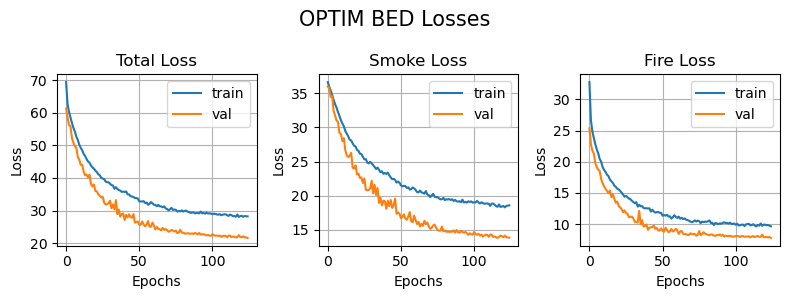

In [20]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()